# calculate thresholds

In [1]:
!pip -q install earthaccess

In [2]:
import pandas as pd
import glob
import create_dataset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import os
import matplotlib.colors as colors

In [3]:
dataframes_folder = 'data/dataframes/'
fn = 'grandmesa_2023_tar_2023-06-01_ref_2023-06-01_2023-09-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2023_tar_2023-06-01_ref_2023-06-01_2023-09-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-03-01_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-12-31_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-12-31_median_100.parquet'
fn = 'iceland_trollaskagi_peninsula_2015_tar_2015-06-27_ref_2015-01-01_2015-03-31_median_100.parquet'
#fn = 'grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_100.parquet'
fn = 'grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_30.parquet'



dataframe = pd.read_parquet(f'{dataframes_folder}{fn}')

all_files = glob.glob(os.path.join(dataframes_folder, "*median_30.parquet"))
dataframe = pd.concat((pd.read_parquet(f) for f in all_files), ignore_index=True)

In [4]:
all_files

['data/dataframes/grandmesa_2016_tar_2016-04-27_ref_2016-06-01_2016-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2018_tar_2018-04-27_ref_2018-06-01_2018-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2020_tar_2020-04-27_ref_2020-06-01_2020-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2015_tar_2015-04-27_ref_2015-06-01_2015-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2022_tar_2022-04-27_ref_2022-06-01_2022-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2019_tar_2019-04-27_ref_2019-06-01_2019-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2017_tar_2017-04-27_ref_2017-06-01_2017-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2023_tar_2023-04-27_ref_2023-06-01_2023-07-31_median_30.parquet',
 'data/dataframes/grandmesa_2021_tar_2021-04-27_ref_2021-06-01_2021-07-31_median_30.parquet']

In [5]:
dataframe = dataframe[dataframe['local_incidence_angle']<101]

In [6]:
ndsi_thresh =  [30,70] # 40 #[40,60] #40 #[40,70]

In [7]:
dataframe = create_dataset.dataframe_ndsi_to_binary(dataframe,ndsi_thresh)

In [8]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']


# Create bins for the 'local_incidence_angle' column
dataframe['local_incidence_angle_bins'] = pd.cut(dataframe['local_incidence_angle'], bins=bins, labels=labels)

dataframe['forest_cover_fraction_bins'] = pd.cut(dataframe['forest_cover_fraction'], bins=bins, labels=labels)

In [9]:
#dataframe.corr(numeric_only=True)

In [10]:
#dataframe = create_dataset.dataframe_numbers_to_classes(dataframe)

In [11]:
parts = fn.split('_')
target_time = parts[parts.index('tar') + 1]

time_diff = (dataframe['time'] - pd.to_datetime(target_time)).abs()
mask = time_diff <= pd.Timedelta(days=10)

dataframe = dataframe[mask]

In [12]:
pal = {0:'peru',1:'dodgerblue'} 

In [13]:
def calculate_threshold_otsu(group):
    values = group['ratio_images'].values
    return threshold_otsu(values)


def calculate_threshold_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        difference_array = np.absolute(0.5-model.predict_proba(X)[:,1])
        index = difference_array.argmin()
        thresh = X.values[index][0]
    else:
        thresh = np.nan 
        
    return thresh 

def calculate_roc_auc_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1],average='weighted') # add average
        
    else:
        auc = np.nan
    
    return auc


def calculate_accuracy_logistic(group):
    X = group[['ratio_images']]
    y = group['modis_binary']
    
    if (len(np.unique(y)) == 2) & (y.value_counts().min()>50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        model = LogisticRegression(class_weight='balanced')
        model.fit(X_train, y_train)
        acc = model.score(X_test,y_test)
    else:
        acc = np.nan
    
    return acc

In [14]:
thresholds_otsu = dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_otsu).reset_index(level=[0,1])

In [15]:
thresholds_logistic = dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_threshold_logistic).reset_index(level=[0,1])

In [16]:
roc_auc_logistic = dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_roc_auc_logistic).reset_index(level=[0,1])

In [17]:
accuracy_logistic = dataframe.groupby(['sat:orbit_state','band','local_incidence_angle_bins']).apply(calculate_accuracy_logistic).reset_index(level=[0,1])

In [18]:
thresholds = thresholds_logistic

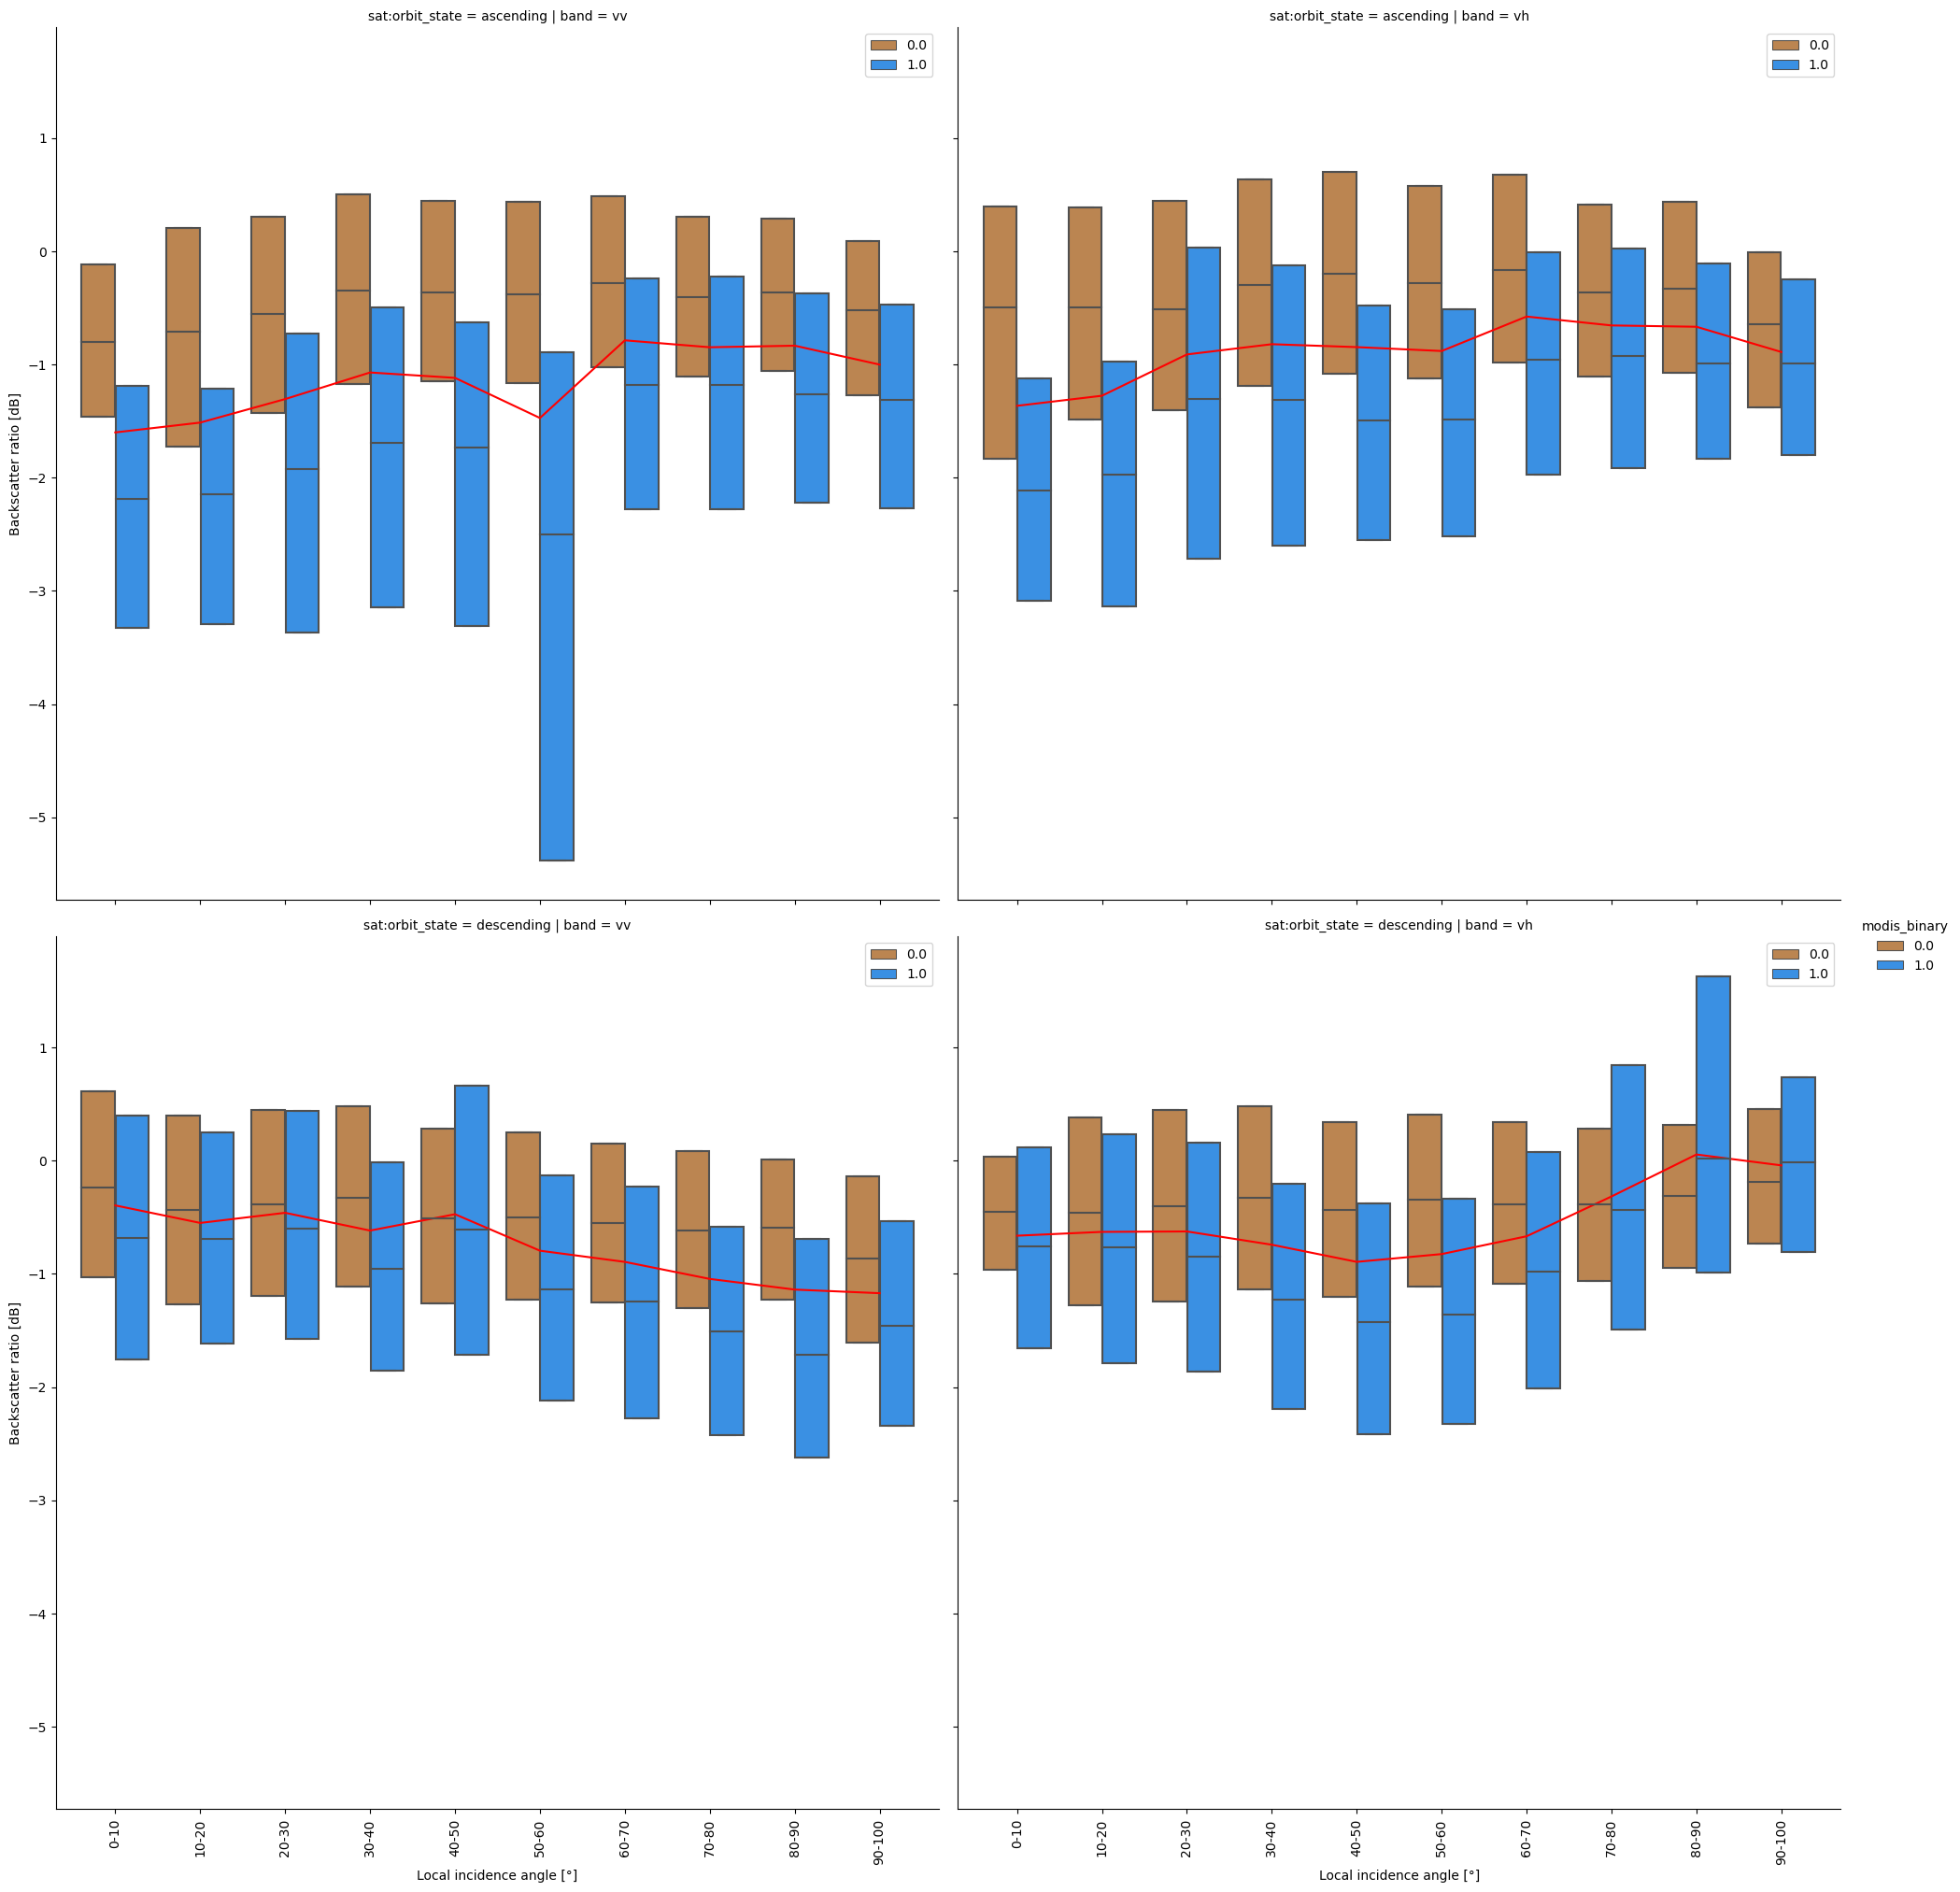

In [19]:
g = sns.catplot(x='local_incidence_angle_bins', y='ratio_images', hue="modis_binary", data=dataframe,
               row="sat:orbit_state", col='band', kind='box', showfliers=False, whis=0, palette=pal, height=10)

row_values = dataframe['sat:orbit_state'].unique()
col_values = dataframe['band'].unique()
row_indices = {value: i for i, value in enumerate(row_values)}
col_indices = {value: i for i, value in enumerate(col_values)}


for (row_value, col_value), _ in g.axes_dict.items():
        row_index = row_indices[row_value]
        col_index = col_indices[col_value]
        
        sns.lineplot(thresholds[(thresholds['sat:orbit_state'] == row_value) & (thresholds['band'] == col_value)],
                     x="local_incidence_angle_bins", y=0, color='red', ax=g.facet_axis(row_index, col_index))
        

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Backscatter ratio [dB]')
    ax.set_xlabel('Local incidence angle [\N{degree sign}]')

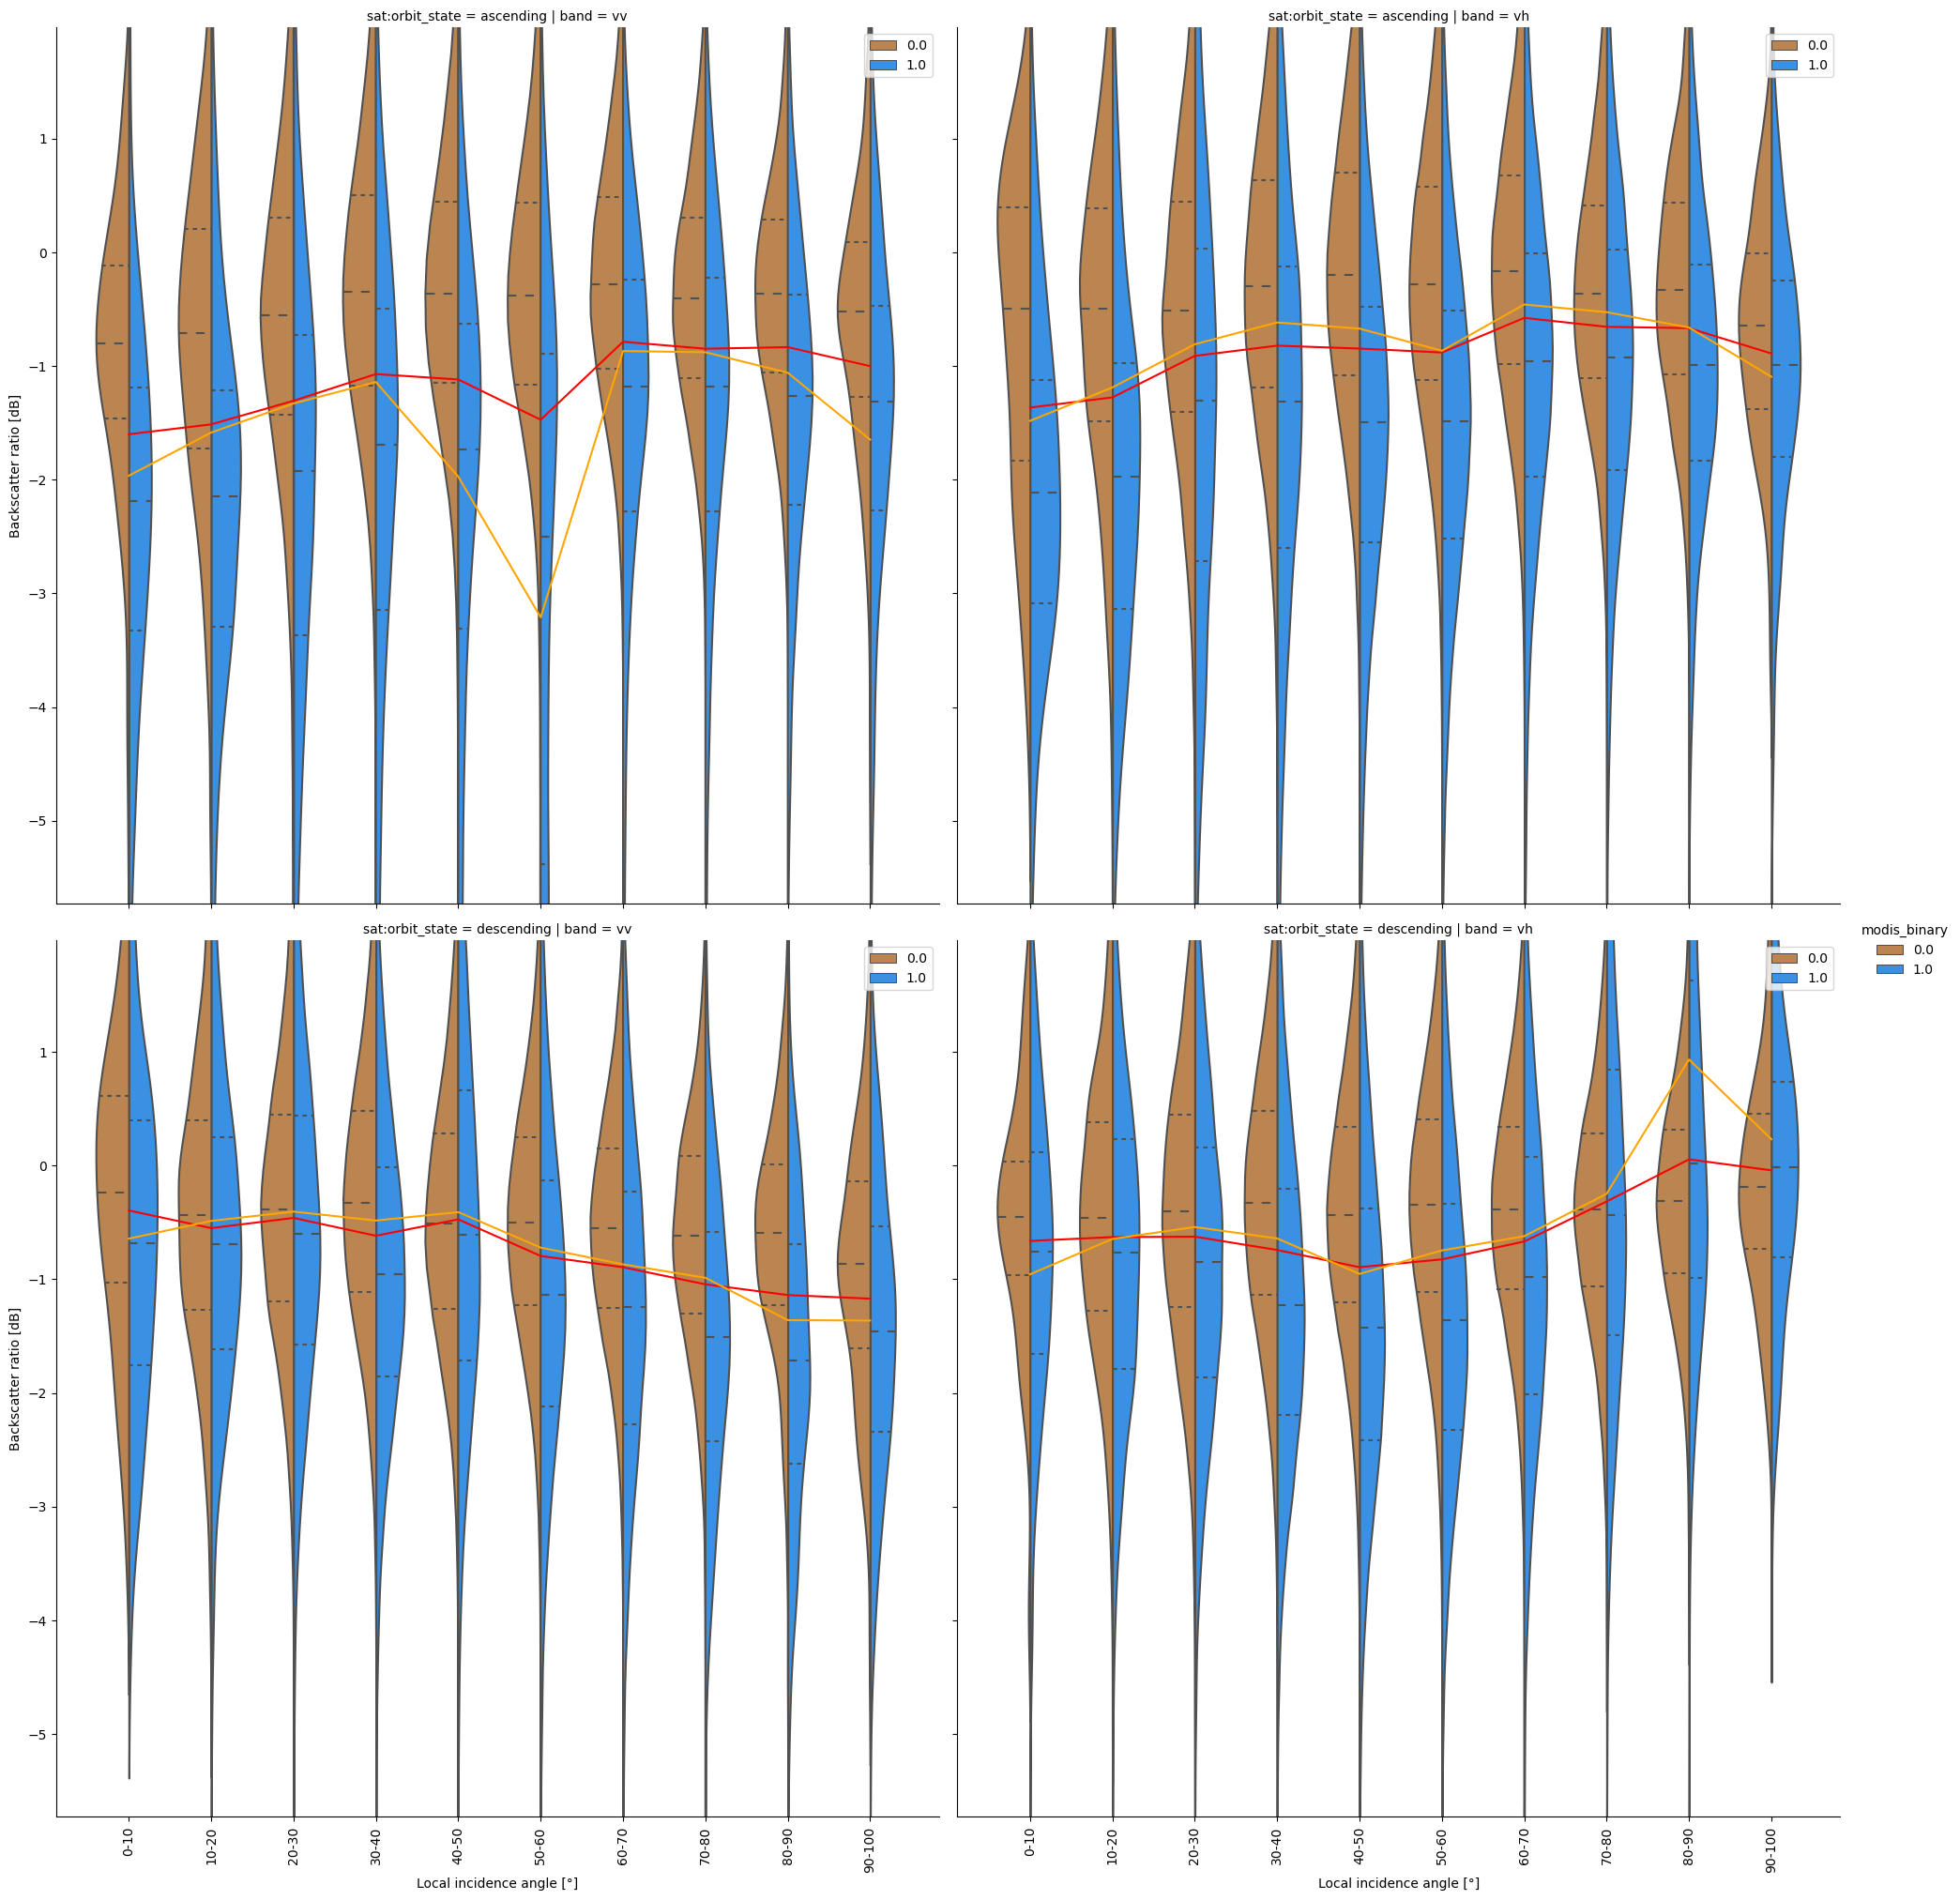

In [20]:
g = sns.catplot(x='local_incidence_angle_bins', y='ratio_images', hue="modis_binary", data=dataframe,
               row="sat:orbit_state", col='band', kind='violin',split=True,inner='quart', palette=pal, height=10)

row_values = dataframe['sat:orbit_state'].unique()
col_values = dataframe['band'].unique()
row_indices = {value: i for i, value in enumerate(row_values)}
col_indices = {value: i for i, value in enumerate(col_values)}
        
for (row_value, col_value), _ in g.axes_dict.items():
        row_index = row_indices[row_value]
        col_index = col_indices[col_value]
        
        sns.lineplot(thresholds_logistic[(thresholds_logistic['sat:orbit_state'] == row_value) & (thresholds_logistic['band'] == col_value)],
                     x="local_incidence_angle_bins", y=0, color='red', ax=g.facet_axis(row_index, col_index))
        sns.lineplot(thresholds_otsu[(thresholds_otsu['sat:orbit_state'] == row_value) & (thresholds_otsu['band'] == col_value)],
                     x="local_incidence_angle_bins", y=0, color='orange', ax=g.facet_axis(row_index, col_index))

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Backscatter ratio [dB]')
    ax.set_xlabel('Local incidence angle [\N{degree sign}]')

In [21]:
# for asc_desc in np.unique(dataframe['sat:orbit_state']):
#     for vv_vh in np.unique(dataframe['band']):
#         new_dataframe = dataframe[(dataframe['sat:orbit_state']==asc_desc) & (dataframe['band']==vv_vh)]

#         X = new_dataframe[['ratio_images','local_incidence_angle','forest_cover_fraction','snow_class']]
#         y = new_dataframe['modis_binary']

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#         model = LogisticRegression()
#         model.fit(X_train, y_train)

#         score = model.score(X_test,y_test)
#         cm = confusion_matrix(y_test,model.predict(X_test))
#         f,ax=plt.subplots(figsize=(9,9))
#         sns.heatmap(cm, annot=True, fmt=".0f", square = True, cmap = 'inferno',ax=ax);
#         ax.set_ylabel('Actual label');
#         ax.set_xlabel('Predicted label');
#         ax.set_title(f'{asc_desc} {vv_vh} accuracy score: {score:.3f}');

In [22]:
# result = permutation_importance(model, X_train, y_train, n_repeats=1000, random_state=42, n_jobs=2)
# print('Permutation importance - average:'.format(), X_train.columns)
# print([round(i, 6) for i in result.importances_mean])

# # displace feature importance
# fig, ax = plt.subplots(figsize=(10,10))
# ax.boxplot(result.importances.T)
# ax.set_title("Permutation Importances", fontsize = 16)
# ax.set_xticklabels(labels=X_train.columns, fontsize=14)
# plt.show()

In [23]:
thresholds_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=True
).apply(calculate_threshold_logistic).reset_index().rename({0:'thresh'},axis='columns') 

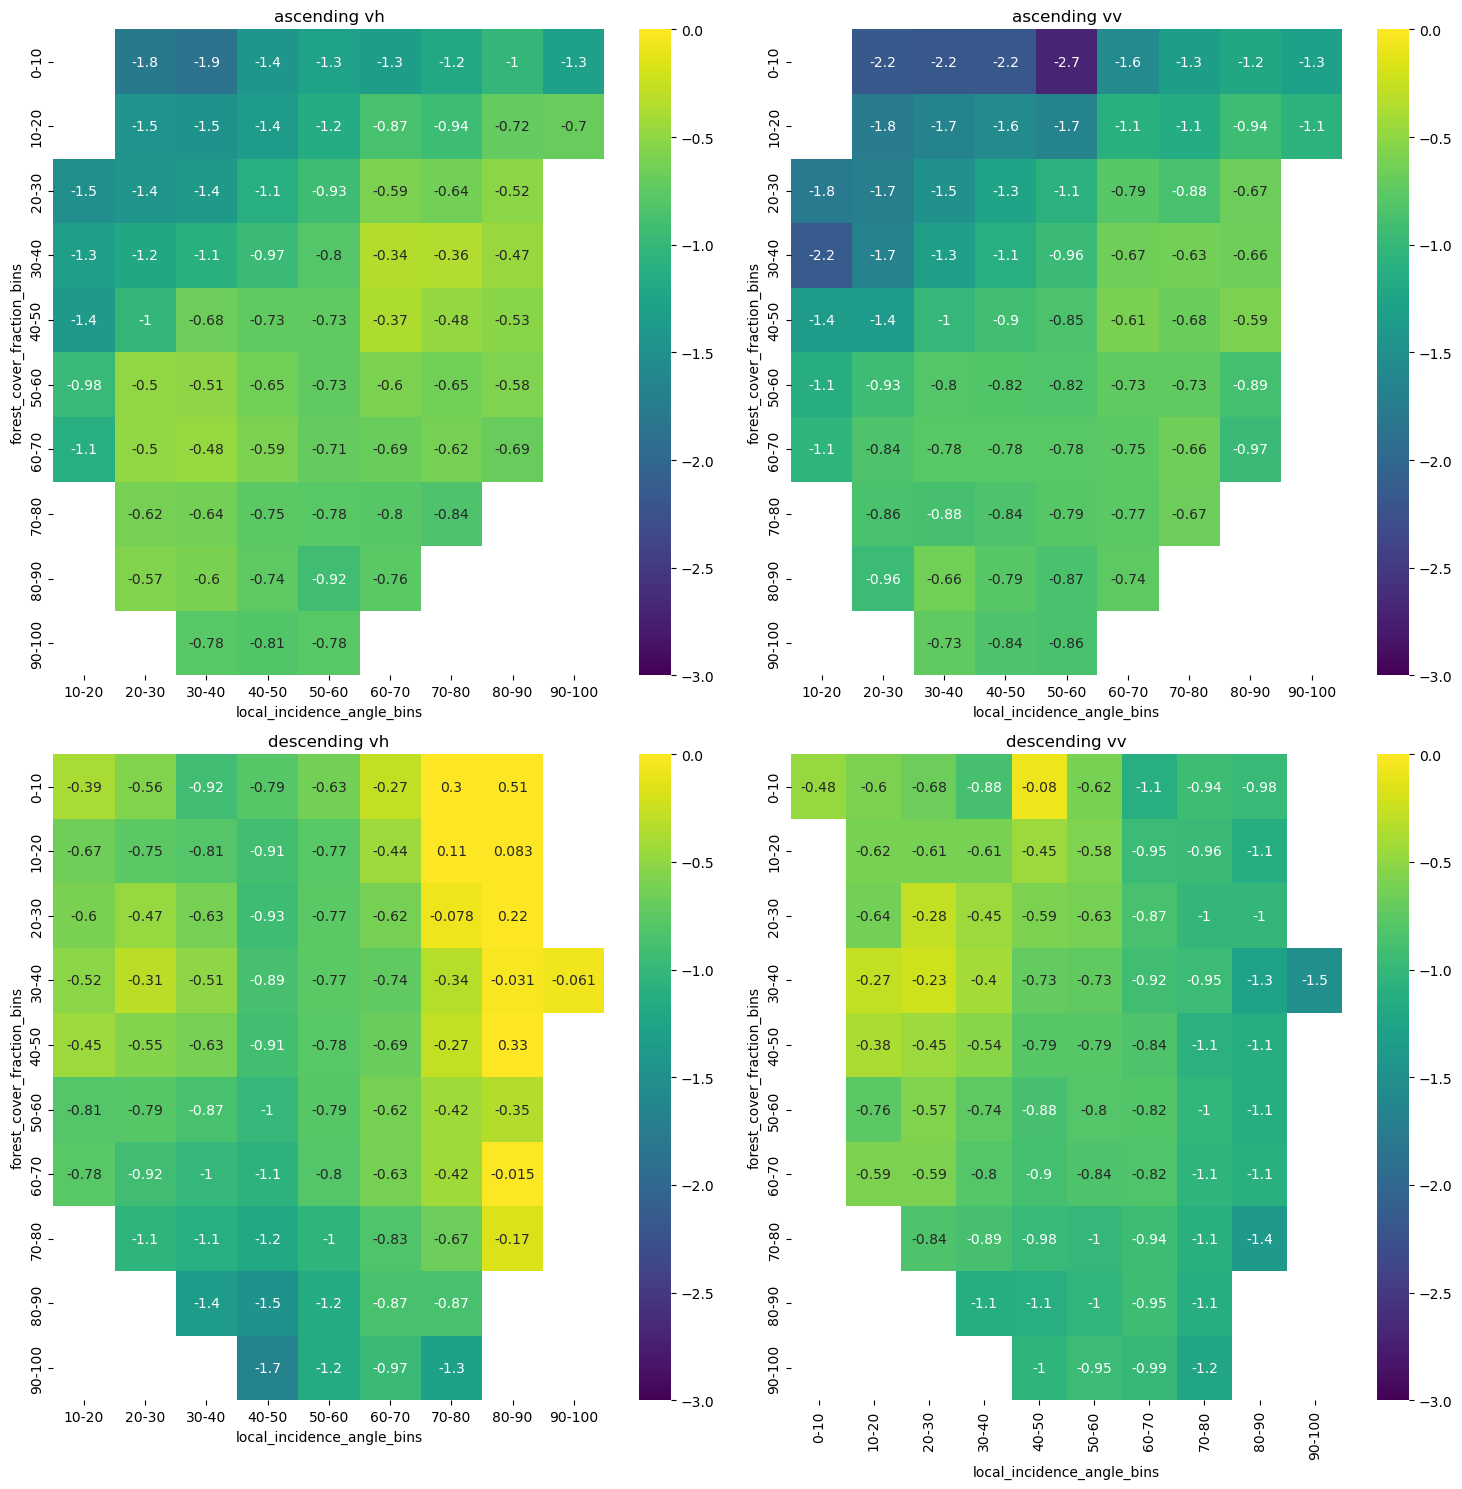

In [24]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
df = thresholds_logistic
var = 'thresh'

# Create a list of combinations for sat:orbit_state and band
combinations = [('ascending', 'vh'), ('ascending', 'vv'), ('descending', 'vh'), ('descending', 'vv')]

# Plot a heatmap in each subplot
for ax, (orbit_state, band) in zip(axs.flatten(), combinations):
    data = df[(df['sat:orbit_state'] == orbit_state) & (df['band'] == band)]
    pivot_table = data.pivot_table(values=var, index='forest_cover_fraction_bins', columns='local_incidence_angle_bins')
    sns.heatmap(pivot_table, ax=ax, cmap='viridis',annot=True, vmin=-3, vmax=0)
    ax.set_title(f'{orbit_state} {band}')

plt.tight_layout()
plt.show()

In [25]:
accuracy_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=True
).apply(calculate_accuracy_logistic).reset_index().rename({0:'acc'},axis='columns') 

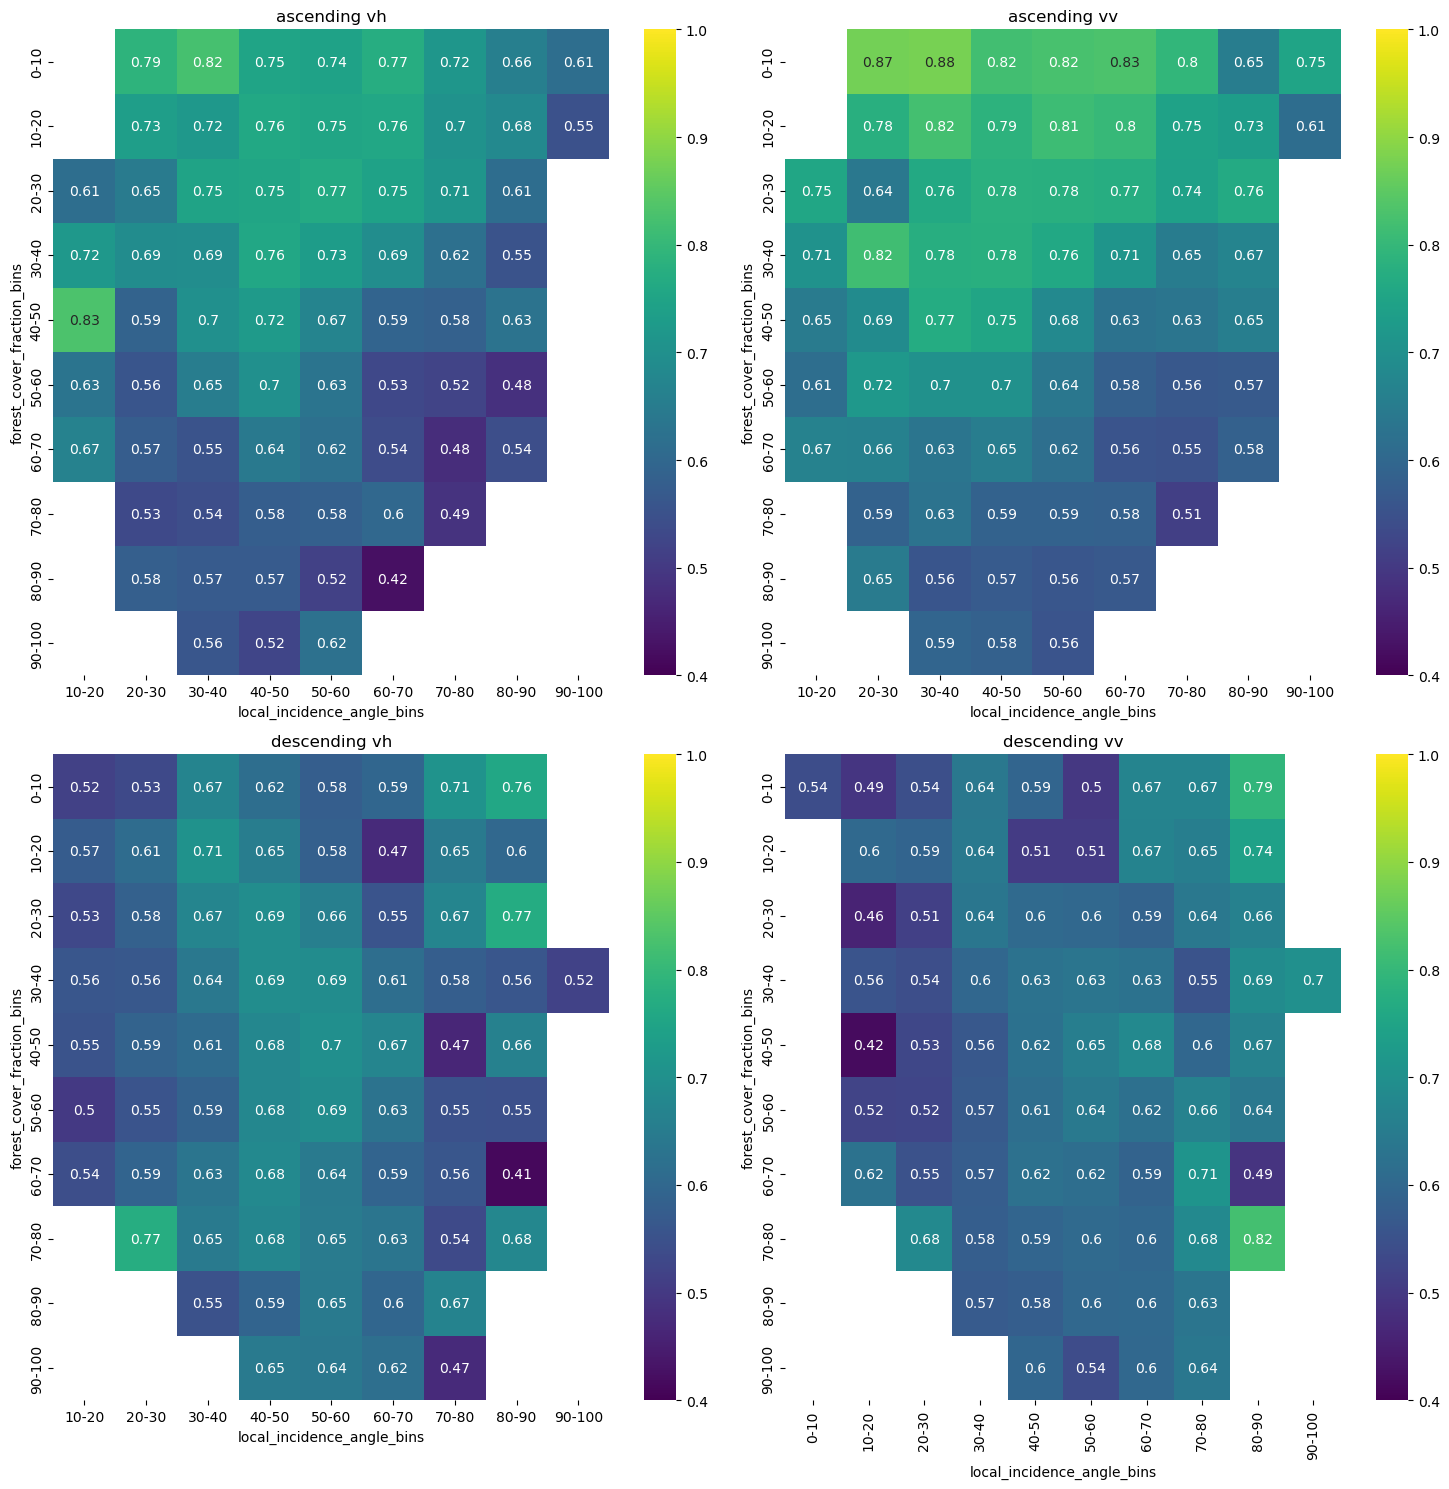

In [26]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
df = accuracy_logistic
var = 'acc'

# Create a list of combinations for sat:orbit_state and band
combinations = [('ascending', 'vh'), ('ascending', 'vv'), ('descending', 'vh'), ('descending', 'vv')]

# Plot a heatmap in each subplot
for ax, (orbit_state, band) in zip(axs.flatten(), combinations):
    data = df[(df['sat:orbit_state'] == orbit_state) & (df['band'] == band)]
    pivot_table = data.pivot_table(values=var, index='forest_cover_fraction_bins', columns='local_incidence_angle_bins')
    sns.heatmap(pivot_table, ax=ax, cmap='viridis',annot=True, vmin=0.4, vmax=1)
    ax.set_title(f'{orbit_state} {band}')

plt.tight_layout()
plt.show()

In [27]:
roc_auc_logistic = dataframe.groupby(
    ['sat:orbit_state','band','local_incidence_angle_bins','forest_cover_fraction_bins'],dropna=True
).apply(calculate_roc_auc_logistic).reset_index().rename({0:'auc'},axis='columns') 

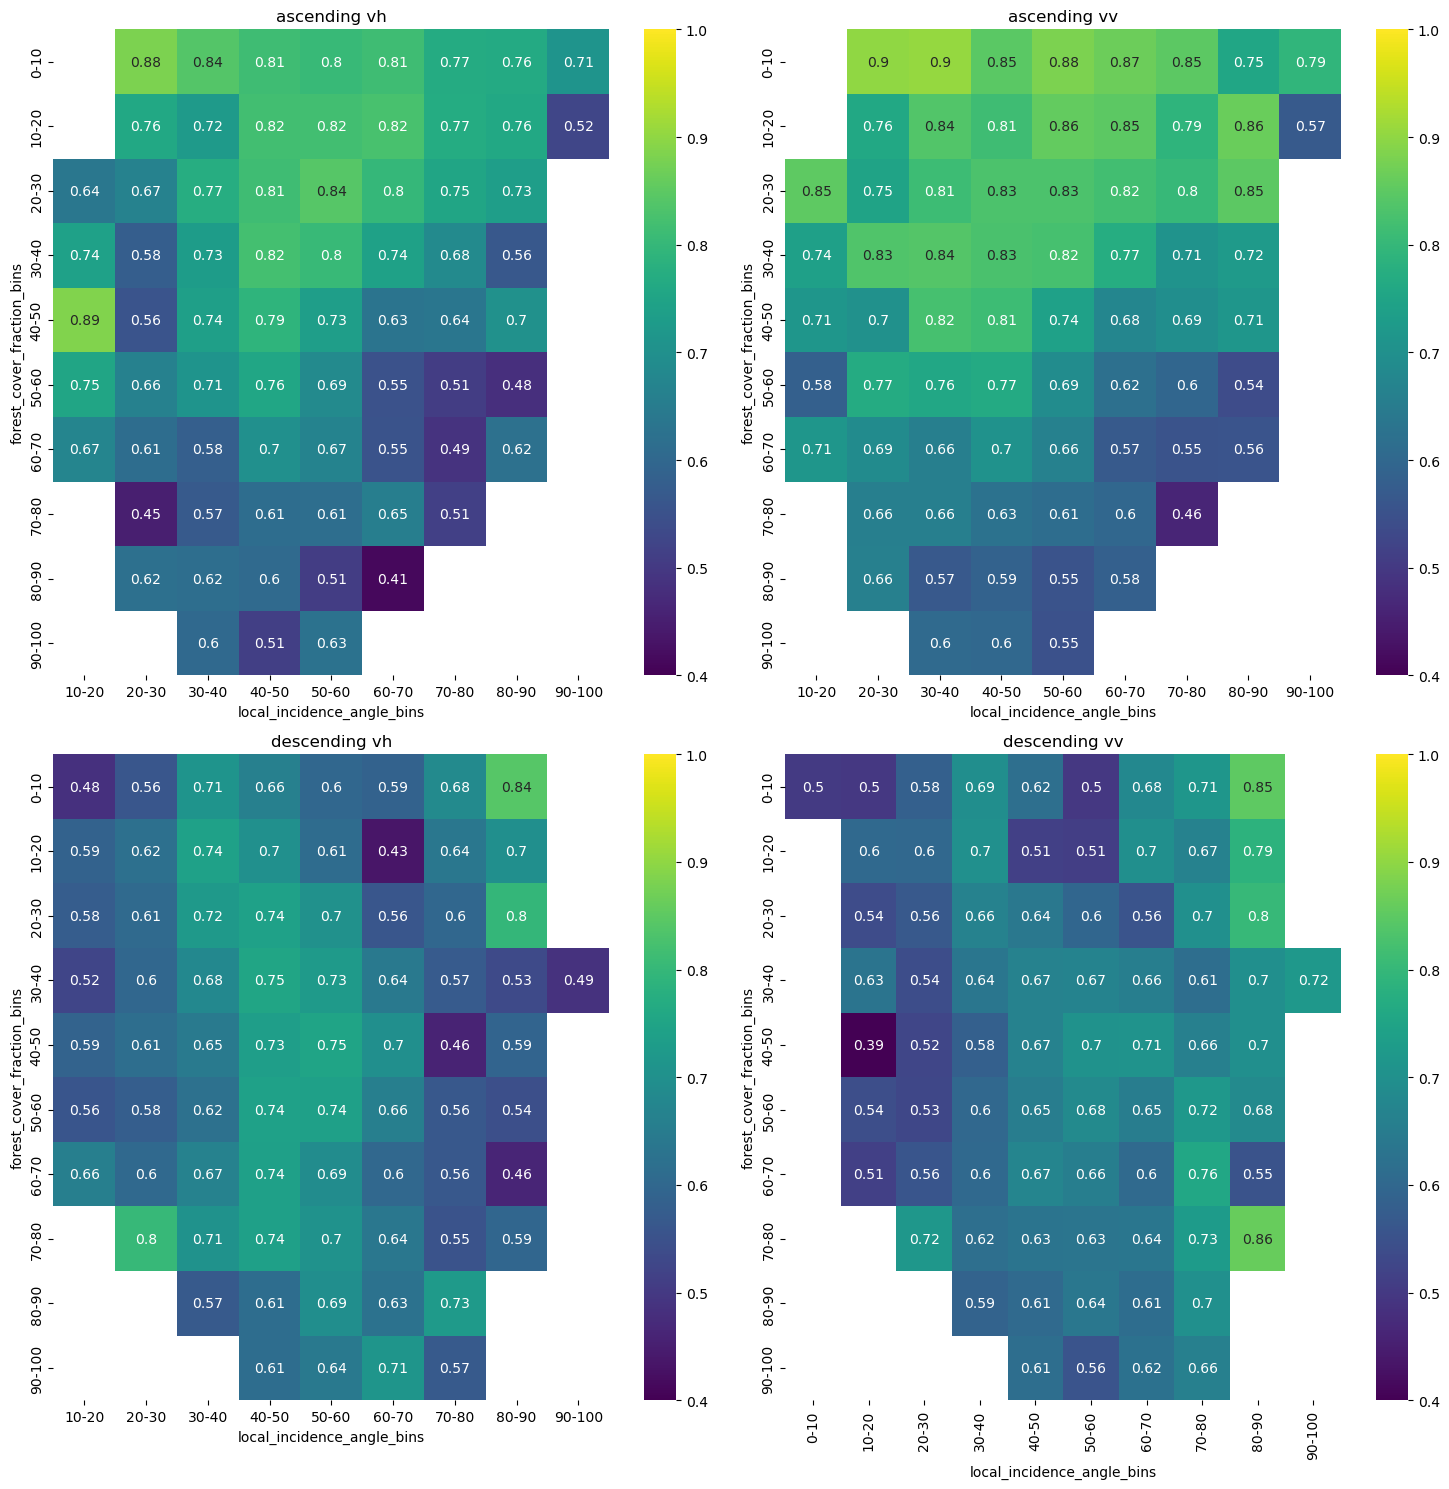

In [28]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
df = roc_auc_logistic
var = 'auc'

# Create a list of combinations for sat:orbit_state and band
combinations = [('ascending', 'vh'), ('ascending', 'vv'), ('descending', 'vh'), ('descending', 'vv')]

# Plot a heatmap in each subplot
for ax, (orbit_state, band) in zip(axs.flatten(), combinations):
    data = df[(df['sat:orbit_state'] == orbit_state) & (df['band'] == band)]
    pivot_table = data.pivot_table(values=var, index='forest_cover_fraction_bins', columns='local_incidence_angle_bins')
    sns.heatmap(pivot_table, ax=ax, cmap='viridis',annot=True, vmin=0.4, vmax=1)
    ax.set_title(f'{orbit_state} {band}')

plt.tight_layout()
plt.show()

In [29]:
idx = roc_auc_logistic.groupby(['local_incidence_angle_bins','forest_cover_fraction_bins'])['auc'].idxmax().dropna() #.reset_index().head(20)

In [30]:
roc_auc_logistic_best = roc_auc_logistic.loc[idx]

In [31]:
roc_auc_logistic_best['band_int'] = roc_auc_logistic_best['band'].apply(lambda x: 0 if x == 'vv' else 1)

Text(0.5, 1.0, 'does vv or vh provide better wet snow seperability?')

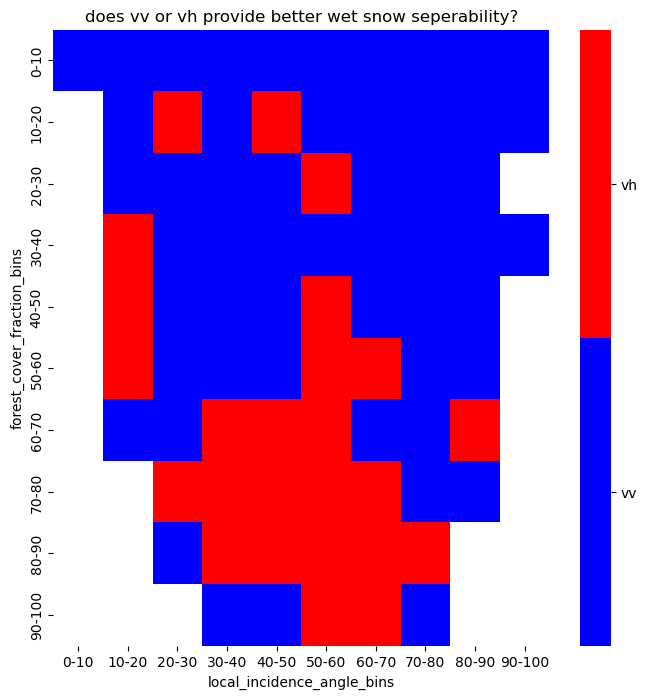

In [32]:
fig, axs = plt.subplots(figsize=(8, 8))


cmap = colors.ListedColormap(['blue', 'red'])

pivot_table = roc_auc_logistic_best.pivot_table(values='band_int', index='forest_cover_fraction_bins', columns='local_incidence_angle_bins')
heatmap = sns.heatmap(pivot_table, cmap=cmap, ax=axs)
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])

# Set the tick labels to 'vv' and 'vh'
colorbar.set_ticklabels(['vv', 'vh'])
axs.set_title('does vv or vh provide better wet snow seperability?')